# Neural Network with Bag of Words

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

from notebooks.models.tokenizers import CustomTokenizer

In [2]:
# Load dataset.csv into a pandas dataframe
df = pd.read_csv('../data/dataset.csv', index_col=0)

# Shuffle dataset
df = df.sample(frac=1)

df.head()

,id,url,title,text,category
50236,11390240,https://en.wikipedia.org/wiki/The%20Journals%2...,The Journals of Susanna Moodie,The Journals of Susanna Moodie is a book of po...,books
161396,52618246,https://en.wikipedia.org/wiki/Pompeii%20Lakshmi,Pompeii Lakshmi,The Pompeii Lakshmi is an ivory statuette that...,art
65456,16364931,https://en.wikipedia.org/wiki/Daikaij%C5%AB%20...,Daikaijū no Gyakushū,is a shoot 'em up arcade video game released b...,video games
71022,18579986,https://en.wikipedia.org/wiki/Frustrated%20Lew...,Frustrated Lewis pair,"In chemistry, a frustrated Lewis pair (FLP) i...",science
135507,41852630,https://en.wikipedia.org/wiki/Cathy%20Osten,Cathy Osten,Catherine A. Osten is an American politician a...,politicians


## Bag of Words


In [3]:
size = 10_000

In [4]:
X = df['text'][:size]
y = df['category'][:size]

X.head()

50236     The Journals of Susanna Moodie is a book of po...
161396    The Pompeii Lakshmi is an ivory statuette that...
65456     is a shoot 'em up arcade video game released b...
71022     In chemistry, a frustrated Lewis pair (FLP)  i...
135507    Catherine A. Osten is an American politician a...
Name: text, dtype: object

In [5]:
# We use the custom tokenizer and remove stopwords
tokenizer = CustomTokenizer(remove_stopwords=True)

X_encoded = X.apply(tokenizer.encode)

X_encoded.head()

50236     [73, 33714, 4582, 12930, 20247, 648, 2363, 323...
161396    [79, 316, 375, 3893, 94786, 939, 8318, 70916, ...
65456     [68392, 364, 336, 48312, 2835, 1847, 6004, 259...
71022     [52755, 11, 33630, 514, 49143, 6857, 320, 1517...
135507    [66, 28107, 264, 13, 297, 16172, 39542, 37038,...
Name: text, dtype: object

In [6]:
# We get the vocabulary
vocab = set()

for tokens in X_encoded:
    for token in tokens:
        vocab.add(token)

vocab_size = len(vocab)
vocab_size

42727

In [7]:
# We create the bag of words

X_encoded = X_encoded.to_frame() 
X_encoded['bow'] = pd.Series(dtype='object')

def create_bow(tokens):
    bow = {}
    for token in tokens:
        if token in bow:
            bow[token] += 1
        else:
            bow[token] = 1
    return bow

X_encoded['bow'] = X_encoded['text'].apply(lambda x: create_bow(x))

X_encoded.head()

,text,bow
50236,"[73, 33714, 4582, 12930, 20247, 648, 2363, 323...","{73: 1, 33714: 1, 4582: 4, 12930: 4, 20247: 5,..."
161396,"[79, 316, 375, 3893, 94786, 939, 8318, 70916, ...","{79: 1, 316: 1, 375: 13, 3893: 13, 94786: 10, ..."
65456,"[68392, 364, 336, 48312, 2835, 1847, 6004, 259...","{68392: 1, 364: 1, 336: 1, 48312: 5, 2835: 6, ..."
71022,"[52755, 11, 33630, 514, 49143, 6857, 320, 1517...","{52755: 1, 11: 69, 33630: 4, 514: 15, 49143: 1..."
135507,"[66, 28107, 264, 13, 297, 16172, 39542, 37038,...","{66: 1, 28107: 4, 264: 2, 13: 39, 297: 30, 161..."


## Format the data to be used in PyTorch

In [8]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

integer_encoded

array([ 3,  2, 17, ...,  3, 18,  3])

In [9]:
# We first need to change the bag of words to a vector so that we can transform it to a tensor
vocab_list = list(vocab)

def bow_to_vector(bow):
    vector = np.zeros(vocab_size)
    for word, count in bow.items():
        index = vocab_list.index(word)
        vector[index] = count
    return vector

tqdm.pandas() # To use progress_apply and better visualize the progress

X_vector = X_encoded['bow'].progress_apply(bow_to_vector)

X_vector.head()

100%|██████████| 10000/10000 [08:20<00:00, 19.97it/s]


50236     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
161396    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
65456     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
71022     [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0,...
135507    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 4.0, ...
Name: bow, dtype: object

In [10]:
# Convert to PyTorch tensors

X = np.array(X_vector.tolist()) # Convert to numpy array

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_tensor.shape, y_tensor.shape

(torch.Size([10000, 42727]), torch.Size([10000]))

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Logistic Regression Model

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

#model = LogisticRegressionModel(vocab_size, num_classes)
model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

MultiLayerPerceptron2(
  (fc1): Linear(in_features=42727, out_features=20, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=10, out_features=20, bias=True)
)
Epoch [1/20], Loss: 1.7150
Precision: 0.5719, Recall: 0.5920, F1 Score: 0.5630
Epoch [2/20], Loss: 0.6995
Precision: 0.7414, Recall: 0.7085, F1 Score: 0.6971
Epoch [3/20], Loss: 0.4821
Precision: 0.7656, Recall: 0.7465, F1 Score: 0.7460
Epoch [4/20], Loss: 0.1507
Precision: 0.7558, Recall: 0.7450, F1 Score: 0.7447
Epoch [5/20], Loss: 0.0727
Precision: 0.7731, Recall: 0.7620, F1 Score: 0.7632
Epoch [6/20], Loss: 0.0280
Precision: 0.7595, Recall: 0.7435, F1 Score: 0.7432
Epoch [7/20], Loss: 0.0511
Precision: 0.7632, Recall: 0.7580, F1 Score: 0.7569
Epoch [8/20], Loss: 0.1011
Precision: 0.7641, Recall: 0.7545, F1 Score: 0.7547
Epoch [9/20], Loss: 0.0142
Precision: 0.7546, Recall: 0.7275, F1 Score: 

## Confusion Matrix

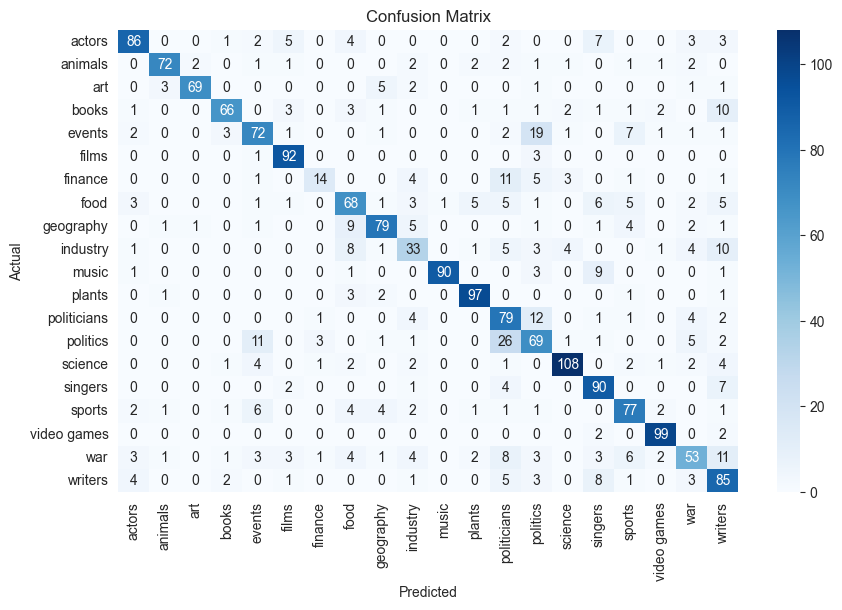

In [13]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_predictions.extend(predicted)
        
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()